# The Capacitated Vehicle Routing Problem

A short example of using Iterated Local Search to model and solve the CRVP

> Vehicle routing problems are inherently intractable: the length of time it takes to solve them grows exponentially with the size of the problem. For sufficiently large problems, it could take OR-tools (or any other routing software) years to find the optimal solution.. 

In [50]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from metapy.tsp.euclidean import gen_matrix, euclidean_distance
from metapy.local_search.two_opt import OrdinaryDecentTwoOpt
from metapy.local_search.random_restarts import (IteratedLocalSearch, 
                                                 EpsilonGreedyHomeBase)
from metapy.tsp.objective import CVRPUnitDemandObjective


from metapy.tsp.init_solutions import VRPPopulationGenerator, TSPPopulationGenerator

from metapy.evolutionary.evolutionary import EvolutionaryAlgorithm
from metapy.evolutionary.strategy import ElitistGeneticAlgorithmStrategy
from metapy.evolutionary.selection import TournamentSelector
from metapy.evolutionary.mutation import TwoOptMutator
from metapy.evolutionary.crossover import PartiallyMappedCrossover

## Parameters

In [2]:
N_PATIENTS = 30
SEED = 101

## Patient Geographic Location

In [3]:
#random number generator for synthetic data.
rand_gen = RandomState(seed=SEED)

#n_patients = 1 so we include the depot
x_coords = rand_gen.random(size=N_PATIENTS+1) * 200
y_coords = rand_gen.random(size=N_PATIENTS+1) * 100

coords = [[x, y] for x, y in zip(x_coords, y_coords)]

In [4]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

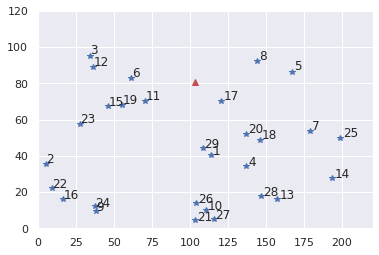

In [5]:
#visualise
plot_patient_coordinates(x_coords, y_coords)

## Approaches to 'solving' the CVRP

* Formulation as a Mixed Integer Programme (MIP) and use of a optimisation solver
* **Heuristic solution**.  E.g. using Iterated Local Search.

## Solution using Iterated Local Search

In [6]:
def create_solver(matrix, capacity, init_solution, random_state=None):
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)
    local_search = OrdinaryDecentTwoOpt(cvrp_obj, init_solution)
    ils = IteratedLocalSearch(cvrp_obj, 
                              local_search, 
                              accept=EpsilonGreedyHomeBase(), 
                              maximisation=False,
                              random_state=random_state)
    return ils

In [28]:
%%time 
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))
ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=19)
ils_solver.run(n=30)

CPU times: user 7.31 s, sys: 16 ms, total: 7.32 s
Wall time: 7.32 s


In [29]:
solution = ils_solver.get_best_solutions()[1][0]

In [30]:
ils_solver.get_best_solutions()[0]

1438.2495606461553

In [10]:
def convert_tour_to_routes(tour, capacity):
    '''
    Easy as demand comes in single units and
    capacity is an integer
    '''
    n_cities = len(tour)
    capacity = int(capacity)
    splits = [i for i in range(capacity, n_cities, capacity)]
    routes = np.split(tour, splits)
    return routes

In [31]:
routes = convert_tour_to_routes(solution[1:], 4)
routes

[array([ 3, 12, 19, 11]),
 array([20, 13, 28,  4]),
 array([ 7, 25, 14, 18]),
 array([24,  9, 16, 22]),
 array([ 6, 15, 23,  2]),
 array([ 8, 30,  5, 17]),
 array([26, 21, 27, 10]),
 array([ 1, 29])]

In [35]:
def plot_solution(routes, x_coords, y_coords):
    
    xc = x_coords
    yc = y_coords
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        plt.plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        plt.plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')
    
    i = 1
    for x, y in zip(x_coords[1:], y_coords[1:]):
        #plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
        i += 1
        

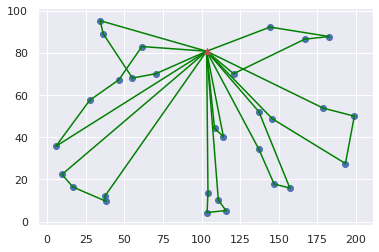

In [33]:
plot_solution(routes, x_coords, y_coords)

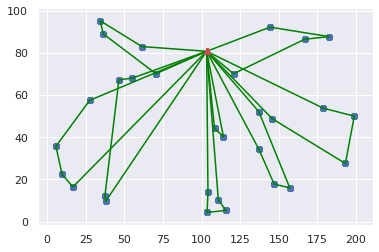

In [14]:
import pandas as pd
active_arcs = pd.read_csv('best_solution_30_patients.csv').to_numpy()

xc = x_coords
yc = y_coords

for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')

## Solution by an Evolutionary Algorithm: Elitist Genetic Algorithm Strategy

In [81]:
#Evolutionary Algorithm - Genetic Algorithm strategy

def create_ga_solver(matrix, capacity, init_solution):

    _lambda = 500
    mew = 60
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)

    init = VRPPopulationGenerator(init_solution)
    strategy = ElitistGeneticAlgorithmStrategy(mew, 
                                               _lambda, 
                                               selector=TournamentSelector(),
                                               xoperator=PartiallyMappedCrossover(),
                                               mutator=TwoOptMutator())

    solver = EvolutionaryAlgorithm(init, cvrp_obj,_lambda, strategy, 
                                   maximisation=False, generations=500)
    return solver

In [82]:
init_solution

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [83]:
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))
solver = create_ga_solver(distance_matrix, 4, init_solution)

In [ ]:
solver.solve()

In [ ]:
solver.best_fitness

In [ ]:
solution2 = solver.best_solution

In [78]:
routes2 = convert_tour_to_routes(solution2[1:], 4)
routes2

[array([29,  1, 28,  4], dtype=int8),
 array([23,  2, 22, 16], dtype=int8),
 array([10, 27, 21, 26], dtype=int8),
 array([11,  3, 12,  6], dtype=int8),
 array([19, 15, 24,  9], dtype=int8),
 array([ 8,  5, 30, 17], dtype=int8),
 array([18,  7, 14, 25], dtype=int8),
 array([20], dtype=int8)]

In [79]:
routes

[array([ 3, 12, 19, 11]),
 array([20, 13, 28,  4]),
 array([ 7, 25, 14, 18]),
 array([24,  9, 16, 22]),
 array([ 6, 15, 23,  2]),
 array([ 8, 30,  5, 17]),
 array([26, 21, 27, 10]),
 array([ 1, 29])]

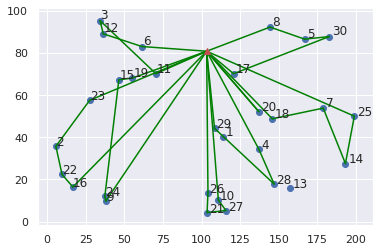

In [80]:
plot_solution(routes2, x_coords, y_coords)

In [66]:
solution2

array([14, 11,  3, 12,  6, 16, 22,  2, 23, 17, 20,  1, 29, 18, 28, 13,  4,
        8,  5, 25,  7, 26, 21, 27, 10, 19, 15,  9, 24, 30], dtype=int8)